In [30]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Профилирование клиентов сети продуктовых магазинов

*Цель*: разделить клиентов на группы(кластеры) на основе их покупательского поведения для разработки персонализированных маркетинговых стратегий

*Данные*: У нас есть датасет с информацией о покупках клиентов, включающих следующие признаки
- Анонимизированные персональные характеристики клиентов магазина
- Информация о количестве покупок клиентов по разным категориям товаров
- Информация о промо-акциях
- Место покупки: онлайн, оффлайн, каталог, количество визитов на сайт магазина


# Загрузка данных

In [31]:
df = pd.read_csv('../Downloads/marketing_campaign.csv', sep = '\t')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

# Предобработка данных

In [32]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [33]:
print(df.isnull().any())

ID                     False
Year_Birth             False
Education              False
Marital_Status         False
Income                  True
Kidhome                False
Teenhome               False
Dt_Customer            False
Recency                False
MntWines               False
MntFruits              False
MntMeatProducts        False
MntFishProducts        False
MntSweetProducts       False
MntGoldProds           False
NumDealsPurchases      False
NumWebPurchases        False
NumCatalogPurchases    False
NumStorePurchases      False
NumWebVisitsMonth      False
AcceptedCmp3           False
AcceptedCmp4           False
AcceptedCmp5           False
AcceptedCmp1           False
AcceptedCmp2           False
Complain               False
Z_CostContact          False
Z_Revenue              False
Response               False
dtype: bool


In [34]:
df = df.dropna()

In [35]:
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], format="%d-%m-%Y")
dates = []
for i in df["Dt_Customer"]:
    i = i.date()
    dates.append(i)  

print("Дата регистрации самого нового клиента:", max(dates))
print("Дата регистрации самого 'старого' клиентa", min(dates))


Дата регистрации самого нового клиента: 2014-06-29
Дата регистрации самого 'старого' клиентa 2012-07-30


In [36]:
dates = pd.to_datetime(dates)

# Количество дней с момента появления нового клиента
df["Customer_For"] = (dates.max() - dates).days

# Проверим, что столбец «Customer_For» содержит только числовые значения.
df["Customer_For"] = pd.to_numeric(df["Customer_For"], errors="coerce")

In [37]:
df["Age"] = 2014 - df["Year_Birth"]

#Общие расходы по различным категориям
df["Spent"] = df["MntWines"] + df["MntFruits"] + df["MntMeatProducts"] + df["MntFishProducts"] + df["MntSweetProducts"] + df["MntGoldProds"]

#Отобразим Marital_Status в пространство с меньшим количеством категорий
df["Living_With"] = df["Marital_Status"].replace({
    "Married": "Partner", 
    "Together": "Partner", 
    "Absurd": "Single", 
    "Widow": "Single", 
    "YOLO": "Single", 
    "Divorced": "Single",
    "Alone": "Single"
})

#Общее количество детей, проживающих в одном доме
df["Children"] = df["Kidhome"] + df["Teenhome"]

#Общее количество людей, проживающих в одном доме
df["Family_Size"] = df["Living_With"].replace({"Single": 1, "Partner": 2})+ df["Children"]

#Введем фичу отображающую является ли клиент родителем
df["Is_Parent"] = np.where(df.Children> 0, 1, 0)

#Разделим Образование на три категории
df["Education"] = df["Education"].replace({
    "Basic": "Undergraduate",
    "2n Cycle": "Undergraduate", 
    "Graduation": "Graduate", 
    "Master": "Postgraduate", 
    "PhD": "Postgraduate"
})

#Для удобства в дальнейшем, переименуем некоторые признаки
df = df.rename(columns = {
    "MntWines": "Wines",
    "MntFruits": "Fruits",
    "MntMeatProducts": "Meat",
    "MntFishProducts": "Fish",
    "MntSweetProducts": "Sweets",
    "MntGoldProds": "Gold"
})

#Удалим избыточные признаки
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth"]
df = df.drop(to_drop, axis=1)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fce1b71d070>,
      dtype=object)

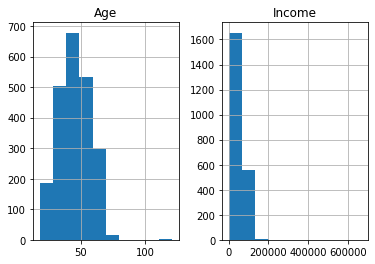

In [38]:
df[['Age', 'Income']].hist()

In [39]:
#Удалим выбросы в признаках возраста и дохода
df = df[(df["Age"] < 90)]
df = df[(df["Income"] < 600000)]

In [40]:
s = (df.dtypes == 'object')
object_cols = list(s[s].index)

print("Категориальные признаки:", object_cols)

Категориальные признаки: ['Education', 'Living_With']


# Перевод категориальных признаков в числовые

Так как любой алгоритм машинного обучения основан на математических операциях, ме не можем использовать категориальные признаки в сыром виде. Поэтому мы  закодируем их тем или иным  методом LabelEncoder, который каждому классу ставит в соответсвие число от 0 до n-1, где n- это количество классов/категорий:
$$ LabelEncoder(category_i) = i $$
$$\ i=1 \dots n $$


In [41]:
LE = LabelEncoder()
for i in object_cols:
    df[i] = df[[i]].apply(LE.fit_transform)

In [42]:
# Нормализируем признаки
ds = df.copy()
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)

scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )

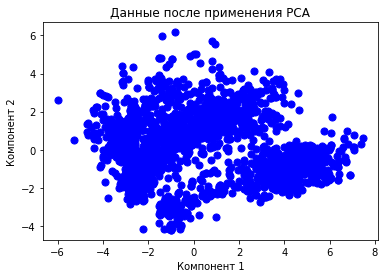

In [43]:
# Визуализация данных клиеннтов с помощью Принципа главных компонент (PCA)
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(scaled_ds)


plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', marker='o', s=50)
plt.title('Данные после применения PCA')
plt.xlabel('Компонент 1')
plt.ylabel('Компонент 2')
plt.show()

## Кластеризация

In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_pca)
kmeans_labels = kmeans.predict(X_pca)
kmeans_score = silhouette_score(X_pca, kmeans_labels)

# Измерение качества кластеров

Силуэтный коэффициент
$$ s =  \frac{b-a}{max(b,a)} $$
Считаетсся для каждого объекта выборки отдельно и берется среднее по всем объектам
$a$ - среднее расстояни от объекта до всех остальных точек его кластера, а $b$ - cреднее расстояние от объекта до точек ближайшего кластера. 

- Если $s$ близко к $1$, это означает, что точка данных находится далеко от соседних кластеров (хорошее разделение) и близко к другим точкам данных внутри своего собственного кластера (хорошая связность)
- Если значение $s$ близко к $0$, это указывает на то, что точка данных находится на границе между двумя кластерами или очень близко к ней.
- Если значение $s$ отрицательное, это говорит о том, что точка данных, возможно, была назначена неправильному кластеру, поскольку она ближе к соседнему кластеру, чем к своему собственному.

In [45]:
# Посчитаем силуэтный коэффициент и инерцию
print("K-Means Силуэтный коэффициент:", kmeans_score)

K-Means Силуэтный коэффициент: 0.45373127312316697


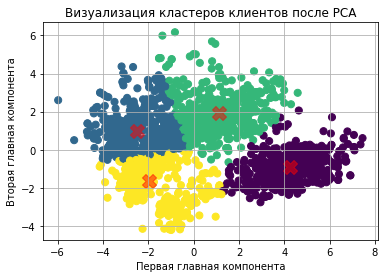

In [46]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans_labels, cmap='viridis', s=50)

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', s=200, alpha=0.5, marker='X')
plt.title('Визуализация кластеров клиентов после PCA')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.grid(True)
plt.show()

In [47]:
df['Clusters'] = kmeans_labels

# Анализ

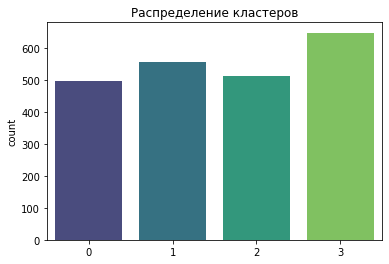

In [48]:
pl = sns.countplot(x = kmeans_labels, palette='viridis')
pl.set_title("Распределение кластеров")
plt.show()

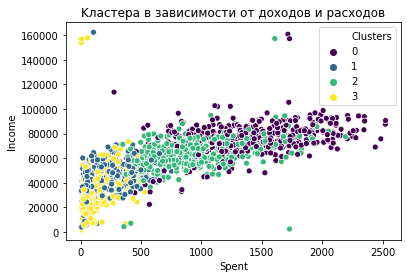

In [49]:
pl = sns.scatterplot(data=df, x=df["Spent"], y=df["Income"], hue=df["Clusters"], palette='viridis')
pl.set_title("Kластера в зависимости от доходов и расходов") 
plt.legend()
plt.show()

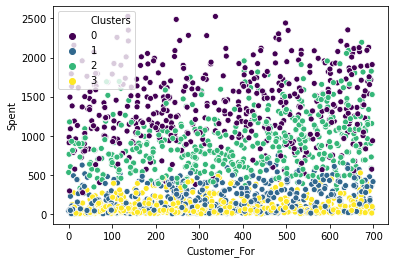

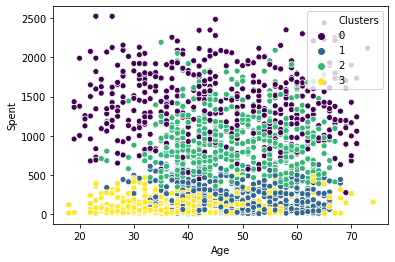

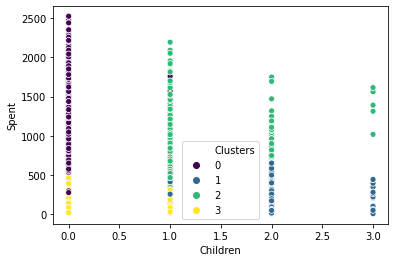

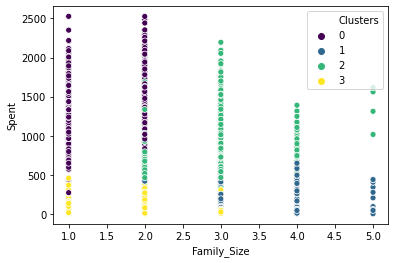

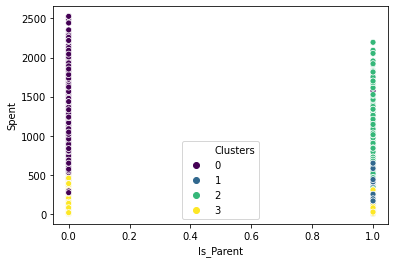

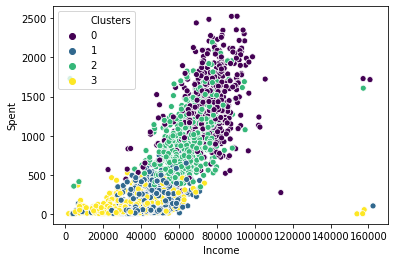

In [51]:
Personal = [ "Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Income"]

for i in Personal:
    plt.figure()
    sns.scatterplot(data=df, x=df[i], y=df["Spent"], hue=df["Clusters"], palette='viridis')
    plt.show()

**Заключение**


*Группа 0:(желтая)*

 - В основном родители.
 - Максимум один ребенок (не подросток).
 - Размер семьи: от 1 до 2 человек.
 - Возраст: от 25 до 40 лет.
 - Низкий доход, низкие расходы.
 
 *Группа 3: (синяя)*


 - Более одного ребенка.
 - Размер семьи: от 4 до 5 человек.
 - Возраст: от 40 до 75 лет.
 - Низкий доход, низкие расходы.

*Группа 2: (зеленая)*

 - В основном не более одного ребенка
 - Размер семьи: от 2 до 4 человек.
 - Возраст: от 40 до 70 лет.
 - Средний доход, но высокие расходы.


*Группа 1(фиолетовая):*  

 - Нет детей.
 - Размер семьи: от 1 до 2 человек.
 - Возраст: от 25 до 75 лет.
 - Высокий доход, высокие расходы.

 
Cегменты клиентов и возможные маркетенговые стратегии:

**Желтая:** Родители с одним ребенком, низкий доход и расходы.
- Скидки на товары для детей: Специальные предложения на одежду, игрушки и книги для детей.

**Синяя** Семьи с несколькими детьми, низкий доход и консервативные расходы
- Экономные предложения: Глубокие скидки на базовые продукты питания, одежду и товары для дома.


**Зеленая** Родители среднего возраста, умеренный доход и высокие расходы
- Семейные акции: Скидки на товары для дома и семейные наборы продуктов


**Фиолетовая:** Люди без детей, высокий доход и расходы
- Персонализированные предложения: Скидки на товары премиум-класса и эксклюзивные товары, на основе предыдущих покупок.

